### Group 28 members:
- Jingze Tian (CCID)
- Letian Ren (CCID)
- Essam Gouda (egouda)

# Task 2: Classification
- Logistic Regression model for female OR male mosquito = function(weather_features)
- Support Vector Machine model for female OR male mosquito = function(weather_features)
- Random Forest model for female OR male mosquito = function(weather_features)

#### Variations for each model:
- 10-fold cross validation for each model was performed
- t-test and ANOVA were used to compare model's performance

# Imports

In [37]:
import pandas as pd
import numpy as np
import time
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from _datetime import datetime

import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white bg for sns plots
sns.set(style="whitegrid", color_codes=True)

import warnings; warnings.simplefilter('ignore')

# Read csv files (datasets)

In [38]:
weather_data = pd.read_csv('./data/weather_data.csv')
mos_data = pd.read_csv('./data/mosquito_data_new.csv')

In [39]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
0,09/15/2015 12:00:00 AM,Aedes,vexans,Female,NaN,3,Rural-West,NaN,Outer,53.562973,-113.787353,POINT (-113.787353 53.5629733)
1,05/12/1998 12:00:00 AM,Male,UnID,Male,UnID,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
2,08/28/2001 12:00:00 AM,Culex,tarsalis,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
3,08/17/2004 12:00:00 AM,Culex,territans,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
4,05/15/2018 12:00:00 AM,Culiseta,impatiens,Female,NaN,2,Rural-West,NaN,Outer,53.559020,-114.001190,POINT (-114.00119 53.559020000000004)


In [40]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,temperature,windchill,humidex,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation
0,2018-12-18 16:00:00 MST,1545174000,91.73,99.7,SW,23.0,5.0,NaN,64.0,-7.3,-1.3,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-18 15:00:00 MST,1545170400,91.67,99.7,S,18.0,5.0,NaN,65.0,-6.3,-0.5,-2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,2018-12-18 14:00:00 MST,1545166800,91.67,99.6,S,17.0,5.0,NaN,51.0,-6.5,2.7,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
3,2018-12-18 13:00:00 MST,1545163200,91.66,99.6,SE,13.0,2.0,NaN,50.0,-6.4,2.9,NaN,NaN,NaN,3.9,NaN,NaN,NaN,NaN
4,2018-12-18 12:00:00 MST,1545159600,91.75,99.7,NaN,NaN,0.0,NaN,59.0,-6.6,0.5,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN


In [41]:
first_row = {'Trap Date':['05/09/2017 12:00:00 AM'], 'Gender':'Male', 'Count':0}
first_row = pd.DataFrame(first_row)
mos_data = mos_data.append(first_row)

## Select dates range for mosquito data

In [42]:
t_list = []
for i in mos_data['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%m/%d/%Y %H:%M:%S AM")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

mos_data['Trap Date'] = t_list


mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])

############data select#############
start_remove = min(weather_data['date_time_local'])
end_remove = max(weather_data['date_time_local'])
mos_data_1 = mos_data.loc[(mos_data["Trap Date"] >= start_remove) & (mos_data["Trap Date"] <= end_remove) ]
mos_date_start = str(mos_data_1['Trap Date'].dt.date.min())
mos_date_end = str(mos_data_1['Trap Date'].dt.date.max())
mos_date_range = mos_date_start +' to ' + mos_date_end
print("Range of dates in mosquito dataset is {}".format(mos_date_range))

mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])
mos_range = (mos_data['Trap Date'] >= mos_date_start) & (mos_data['Trap Date'] <= mos_date_end)
mos_data = mos_data.loc[mos_range]
mos_data = mos_data.sort_values(by='Trap Date')


mos_count = mos_data.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count[mos_count['Count'] == mos_count['Count'].max()]

Range of dates in mosquito dataset is 2017-05-09 to 2018-09-25


,Count
Trap Date,
2018-06-12,9938


In [43]:
mos_data.head()

,Comparison Group,Count,Gender,Genus,IDd,Include,Latitude,Location,Longitude,Specific Epithet,Trap Date,Trap Region
0,NaN,0,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-09,NaN
6843,Outer,2,Female,Culiseta,NaN,NaN,53.562973,POINT (-113.787353 53.5629733),-113.787353,inornata,2017-05-09,Rural-West
17781,Peripheral,1,Female,Culiseta,NaN,NaN,53.619232,POINT (-113.7127984 53.6192317),-113.712798,inornata,2017-05-09,Rural-North West
19436,Peripheral,2,Female,Culiseta,NaN,NaN,53.528587,POINT (-113.7380701 53.5285872),-113.738070,alaskaensis,2017-05-09,Rural-South West
16953,Outer,2,Female,Culiseta,NaN,NaN,53.333327,POINT (-113.5313737 53.3333269),-113.531374,inornata,2017-05-09,Outer Community-South1


In [44]:
mos_count.head()

,Count
Trap Date,
2017-05-09,26
2017-05-16,29
2017-05-23,523
2017-05-30,363
2017-06-06,1656


## Select dates range for weather data

In [45]:
start_date1 = '2017-05-03' #one week before 2017-05-09
end_date1 = '2017-09-26'
start_date2 = '2018-05-09' #one week before 2018-05-15
end_date2 = '2018-09-25'

##############Drop MST###################
weather_data.drop(columns=["visibility", "cloud_cover_4", "cloud_cover_8", "cloud_cover_10", "solar_radiation", "wind_gust", "windchill", "humidex"], inplace=True)
weather_data = weather_data.loc[weather_data['date_time_local'].str.contains('MDT')]


t_list = []
for i in weather_data['date_time_local']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d %H:%M:%S MDT")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

weather_data['date_time_local'] = t_list


weather_data['date_time_local'] = pd.to_datetime(weather_data['date_time_local'])
weather_range1 = (weather_data['date_time_local'] >= start_date1) & (weather_data['date_time_local'] <= end_date1)
weather_data1 = weather_data.loc[weather_range1]
weather_data1 = weather_data1.sort_values(by='date_time_local')


weather_range2 = (weather_data['date_time_local'] >= start_date2) & (weather_data['date_time_local'] <= end_date2)
weather_data2 = weather_data.loc[weather_range2]
weather_data2 = weather_data2.sort_values(by='date_time_local')
weather_data = weather_data1.append(weather_data2)

In [46]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,relative_humidity,dew_point,temperature,health_index
14273,2017-05-03,1493791200,93.91,101.9,SW,21.0,3.0,64.0,0.3,6.6,3.0
14250,2017-05-03,1493874000,93.51,101.4,SW,22.0,7.0,50.0,2.6,12.7,3.7
14251,2017-05-03,1493870400,93.49,101.4,SW,24.0,6.0,48.0,2.0,12.9,3.5
14252,2017-05-03,1493866800,93.44,101.3,WNW,29.0,5.0,34.0,1.0,17.1,3.3
14253,2017-05-03,1493863200,93.38,101.3,W,27.0,7.0,28.0,0.2,18.9,3.3


## Seperate mosquito data by gender

In [47]:
mos_data_male = mos_data.loc[mos_data['Gender'].str.contains('Male')]
mos_data_female = mos_data.loc[mos_data['Gender'].str.contains('Female')]

mos_count_male = mos_data_male.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count_male[mos_count_male['Count'] == mos_count_male['Count'].max()]


mos_count_female = mos_data_female.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count_female[mos_count_female['Count'] == mos_count_female['Count'].max()]


mos_count_male["Count_female"] = mos_count_female["Count"]
mos_count_male['Gender'] = np.where(mos_count_male["Count"] > mos_count_male["Count_female"], 'Male', 'Female')
#compare count

gender = np.array(mos_count_male['Gender'])

## Grouping both datasets
- For justifications for the methods of grouping the weather data please refer to task 1

#### weather data grouping by days then weekly

In [48]:
weather_data_grouped = weather_data.groupby('date_time_local', as_index=False).agg({
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

287


In [49]:
weather_data_grouped.sort_values('date_time_local', inplace=True)
weather_data_grouped.head(7)

,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-03,93.87,101.50,20.0,7.0,-1.6,18.9,2.8
1,2017-05-04,93.64,101.40,22.0,7.0,1.9,8.4,3.2
2,2017-05-05,92.13,100.25,15.0,13.0,4.6,27.2,2.8
3,2017-05-06,92.68,100.30,28.0,13.0,5.2,14.9,2.4
4,2017-05-07,93.48,101.30,31.0,18.0,-3.0,6.3,2.2
5,2017-05-08,93.54,101.60,31.0,8.0,-4.8,14.0,2.9
6,2017-05-09,93.62,101.60,32.0,7.0,2.1,16.7,2.9


In [50]:
weather_data_grouped = weather_data_grouped.groupby(weather_data_grouped.index // 7).agg({
    'date_time_local': 'last',
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

## NOTE GROUPING DATA BY WEEK LED TO LOWER ACCURACY

41


#### mosquito data grouping by date

In [51]:
mos_data_grouped = mos_data.groupby(['Trap Date', 'Specific Epithet'], as_index=False).agg({
    'Count' : 'sum',
    'Genus': lambda x: x.value_counts().index[0],
    'Gender': lambda x: x.value_counts().index[0]
})

#### merging both dataset by date

In [52]:
merged_data = pd.merge(left=mos_data_grouped, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')
merged_data.drop(columns=['date_time_local'], inplace=True)

In [53]:
merged_data.head()

,Trap Date,Specific Epithet,Count,Genus,Gender,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-09,alaskaensis,4,Culiseta,Female,93.87,101.4,31.0,7.0,5.2,6.3,2.7
1,2017-05-09,incidens,1,Culiseta,Female,93.87,101.4,31.0,7.0,5.2,6.3,2.7
2,2017-05-09,inornata,18,Culiseta,Female,93.87,101.4,31.0,7.0,5.2,6.3,2.7
3,2017-05-09,spp.,2,Culiseta,Female,93.87,101.4,31.0,7.0,5.2,6.3,2.7
4,2017-05-09,territans,1,Culex,Female,93.87,101.4,31.0,7.0,5.2,6.3,2.7


#### split datasets into male and female datasets

In [54]:
mos_data_male = mos_data.loc[mos_data['Gender'].str.contains('Male')]
mos_data_female = mos_data.loc[mos_data['Gender'].str.contains('Female')]


mos_count_male = mos_data_male.groupby(["Trap Date"], as_index=False).agg({
    "Count":"sum",
})
mos_count_male[mos_count_male['Count'] == mos_count_male['Count'].max()]



mos_count_female = mos_data_female.groupby(["Trap Date"], as_index=False).agg({
    "Count":"sum",
})
mos_count_female[mos_count_female['Count'] == mos_count_female['Count'].max()]


mos_count_male["Count_female"] = mos_count_female["Count"]
mos_count_male['Gender'] = np.where(mos_count_male["Count"] > mos_count_male["Count_female"], 'Male', 'Female')

In [55]:
t_list = []
for i in mos_count_male['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d 00:00:00")
    t2 = time.strftime("%Y-%m-%d 00:00:00", t1)
    t_list.append(t2)

mos_count_male['Trap Date'] = t_list

In [56]:
mos_count_male.head()

,Trap Date,Count,Count_female,Gender
0,2017-05-09 00:00:00,0,26,Female
1,2017-05-16 00:00:00,6,23,Female
2,2017-05-23 00:00:00,325,198,Male
3,2017-05-30 00:00:00,213,150,Male
4,2017-06-06 00:00:00,1130,526,Male


In [57]:
merged_data["Gender"] = mos_count_male["Gender"]
merged_data.drop(columns=['Count'], inplace=True)
merged_data.head()

,Trap Date,Specific Epithet,Genus,Gender,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-09,alaskaensis,Culiseta,Female,93.87,101.4,31.0,7.0,5.2,6.3,2.7
1,2017-05-09,incidens,Culiseta,Female,93.87,101.4,31.0,7.0,5.2,6.3,2.7
2,2017-05-09,inornata,Culiseta,Male,93.87,101.4,31.0,7.0,5.2,6.3,2.7
3,2017-05-09,spp.,Culiseta,Male,93.87,101.4,31.0,7.0,5.2,6.3,2.7
4,2017-05-09,territans,Culex,Male,93.87,101.4,31.0,7.0,5.2,6.3,2.7


In [58]:
len(merged_data.index)

626

In [59]:
merged_data['isWarm'] = np.where(merged_data['temperature'] >= 20, 1, 0)

In [60]:
merged_data['isWindy'] = np.where(merged_data['wind_speed'] >= 25, 1, 0)

In [61]:
merged_data['Genus'] = merged_data['Genus'].astype('category')
merged_data['genusCat'] = merged_data['Genus'].cat.codes

In [62]:
merged_data['Specific Epithet'] = merged_data['Specific Epithet'].astype('category')
merged_data['epithetCat'] = merged_data['Specific Epithet'].cat.codes

In [63]:
merged_data['genderCat'] = np.where(merged_data['Gender'] == "Female", 1, 0)

In [64]:
merged_data["delta_pressure"] = merged_data.apply(lambda x: x['pressure_station'] - x['pressure_sea'], axis=1)

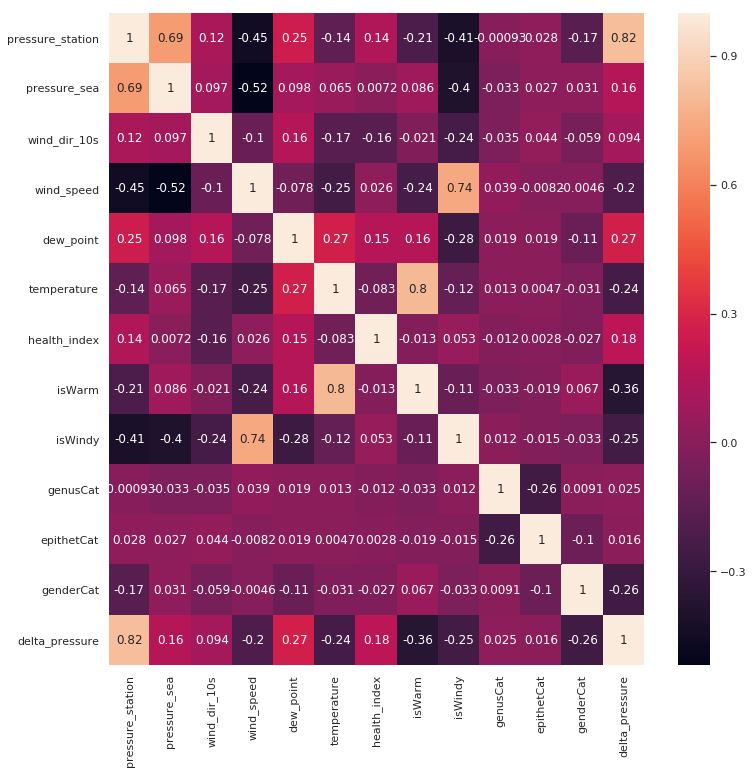

In [65]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(merged_data.corr(), annot=True, ax=ax)

# Classification

## 1) Logistic Regression

In [66]:
cat = merged_data['Gender'].values
x1 = merged_data['wind_speed'].values
x2 = merged_data['wind_dir_10s'].values
x3 = merged_data['genusCat'].values
x4 = merged_data['delta_pressure'].values

In [67]:
cat1 = np.ones(len(cat)) #for non-linear
for j in range(len(cat)):
    if cat[j]=='Male':
        cat1[j] = 0
    else:
        cat1[j] = 1
Labels = cat1.reshape(len(cat1),1)

In [68]:


# plt.scatter(x1[cat=='Male'],x2[cat=='Male'], label='Male')
# plt.scatter(x1[cat=='Female'],x2[cat=='Female'], label='Female')
# plt.xlabel('wind_speed')
# plt.ylabel('dew_point')
# plt.legend()
# plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter()


#### Polynomial features

In [69]:
x3 = (x1,x2, x3,x4)
x3 = np.array(x3)
x3 = x3.T

poly_features = PolynomialFeatures(degree = 2)
X_poly = poly_features.fit_transform(x3)


#### Logistic regression with polynomial features and no regularization

In [70]:
logreg = linear_model.LogisticRegression(solver='lbfgs',multi_class='auto')
logreg.fit(X_poly,cat1)
Yp = logreg.predict(X_poly)
cm = confusion_matrix(cat1, Yp)
print(pd.DataFrame(cm))
tn, fp, fn, tp = cm.flatten()
tot = np.sum(cm)
print("Model accuracy:",(tn+tp)/tot)
print("Misclassified:",(fn+fp)/tot)
print("% of error of true No:",fn/(fn+tn)*100)
print("% of error of true Yes:",fp/(fp+tp)*100)

   0    1
0  0   20
1  0  606
Model accuracy: 0.9680511182108626
Misclassified: 0.03194888178913738
% of error of true No: nan
% of error of true Yes: 3.1948881789137378


#### Logistic regression with polynomial features and L2 regularization

In [71]:
logreg_r2 = linear_model.LogisticRegression(solver='liblinear',multi_class='auto', penalty="l2")
logreg_r2.fit(X_poly,cat1)
Yp = logreg_r2.predict(X_poly)
cm = confusion_matrix(cat1, Yp)
print(pd.DataFrame(cm))
tn, fp, fn, tp = cm.flatten()
tot = np.sum(cm)
print("Model accuracy:",(tn+tp)/tot)
print("Misclassified:",(fn+fp)/tot)
print("% of error of true No:",fn/(fn+tn)*100)
print("% of error of true Yes:",fp/(fp+tp)*100)

   0    1
0  0   20
1  0  606
Model accuracy: 0.9680511182108626
Misclassified: 0.03194888178913738
% of error of true No: nan
% of error of true Yes: 3.1948881789137378


#### Logistic regression with polynomial features and L1 regularization

In [72]:
logreg_r1 = linear_model.LogisticRegression(solver='liblinear',multi_class='auto', penalty="l1")
logreg_r1.fit(X_poly,cat1)
Yp = logreg_r1.predict(X_poly)
cm = confusion_matrix(cat1, Yp)
print(pd.DataFrame(cm))
tn, fp, fn, tp = cm.flatten()
tot = np.sum(cm)
print("Model accuracy:",(tn+tp)/tot)
print("Misclassified:",(fn+fp)/tot)
print("% of error of true No:",fn/(fn+tn)*100)
print("% of error of true Yes:",fp/(fp+tp)*100)

   0    1
0  0   20
1  0  606
Model accuracy: 0.9680511182108626
Misclassified: 0.03194888178913738
% of error of true No: nan
% of error of true Yes: 3.1948881789137378


L1 regularization model creates the best results so its chosen.

In [73]:
# xg = np.linspace(x1.min(), x1.max(), len(x1))
# yg = np.linspace(x2.min(), x2.max(), len(x2))
# xx, yy = np.meshgrid(xg,yg)
# plt.xlim(xx.min(), xx.max())
# # plt.ylim(yy.min(), yy.max())
# Xcont = poly_features.fit_transform(np.vstack((xx.ravel(),yy.ravel())).T)
# Z = logreg.predict(Xcont).reshape(xx.shape)
# plt.contour(xx,yy,Z,levels=1)
# plt.scatter(x1,x2,c=Yp)
# plt.title("Using scikit-learn")
# plt.show()
print("Model accuracy:",accuracy_score(cat1,Yp))

Model accuracy: 0.9680511182108626


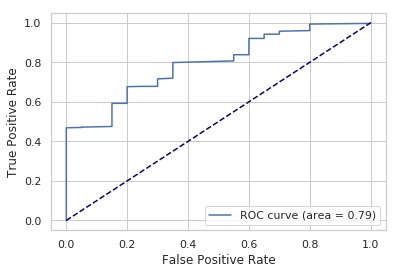

In [74]:
Yprob = logreg.predict_proba(X_poly)
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(cat1, Yprob[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## 2) SVM

In [75]:
def plot_svm_decision_margin(model, plot_support=True):
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   s=200, linewidth=1, edgecolors='black', facecolors='none');
    plt.show()

#### SVM with linear kernal

In [76]:
model_soft = SVC(kernel='linear')
model_soft.fit(x3, cat1)
Yp_soft = model_soft.predict(x3)
# plt.scatter(x1, x2, c=Yp_soft, cmap='winter')
# plot_svm_decision_margin(model_soft)
print("Soft Margin Model accuracity:",accuracy_score(cat1,Yp_soft))

Soft Margin Model accuracity: 0.9680511182108626


#### SVM with rbf kernal

In [77]:
model_soft_rbf = SVC(kernel='rbf')
model_soft_rbf.fit(x3, cat1)
Yp_soft = model_soft_rbf.predict(x3)
# plt.scatter(x1, x2, c=Yp_soft, cmap='winter')
# plot_svm_decision_margin(model_soft_rbf)
print("Soft Margin Model accuracity:",accuracy_score(cat1,Yp_soft))

Soft Margin Model accuracity: 0.9760383386581469


## 3) Random forest

In [78]:
from sklearn import tree

def build_forest(X, y, n_trees, max_depth=None):
    forest = []
    for i in range(n_trees):
        model = tree.ExtraTreeClassifier(max_depth=max_depth)
        model.fit(X,y)
        forest.append(model)
    return forest

def rf_predict(forest, X):
    Yps = []
    for m in forest:
        Yps.append(m.predict(X))
    Yps = np.array(Yps).T
    Yp = []
    for i in range(len(X)):
        val, counts = np.unique(Yps[i], return_counts=True)
        j = np.argmax(counts)
        Yp.append(val[j])
    return np.array(Yp).reshape(len(X),1)

forest = build_forest(x3, cat1, 25, 12)

def plot_decision_rf(X, Y, forest, title):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = rf_predict(forest, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:,0],X[:,1],c=Y)
    plt.title(title)

def plot_decision_sl(X, Y, tree, title):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:,0],X[:,1],c=Y)
    plt.title(title)

In [79]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10, random_state=0, max_depth=12)
model.fit(x3, cat1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [80]:
# plot_decision_sl(x3, cat1, model, "Random Forest Scikit-learn")

In [81]:
Yp = model.predict(x3)
print("Model accuracity (Random Forest):",accuracy_score(cat1,Yp))

Model accuracity (Random Forest): 0.9792332268370607


# Evaluation

In [82]:
from sklearn import model_selection

# prepare configuration for cross validation test harness
seed = 7

models = []

models.append(('LR', linear_model.LogisticRegression(solver='liblinear',multi_class='auto', penalty="l1")))
models.append(('SVM', SVC(kernel='rbf')))
models.append(('RF', RandomForestClassifier(n_estimators=10, random_state=0, max_depth=12)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    if name == 'LR':
        cv_results = model_selection.cross_val_score(model, X_poly, cat1, cv=kfold, scoring=scoring)
    else:
        cv_results = model_selection.cross_val_score(model, x3, cat1, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0

In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()